# ResNet
- Cifar10
- Notebook@Kaggle
- Python 3.8.5
- 仅使用d2l库用于绘制图表
- 使用随机梯度下降（SGD）优化器、余弦退火学习率调度器、权重衰减
- 交叉熵损失函数
- Cuda加速（GPU加速）
- 使用pytorch、torchvision内置方法加载数据集，未使用d2l中的load_Data_Cifar10()函数
- 使用sklearn.metrics模块获得测试准确率和F1得分
- 使用自定义的train()函数
- 为什么要重写Train():
    d2l中内置的train_ch13已经能满足需求但是没法再堆叠打印出F1得分并且trainloss在过程中一直是趋近于0不符合实际我觉得存在bug并且使用自定义的Train()可以更自由的调节lr，在需要查看整个过程中的数据在GoogleNet中可以查看所有的数据做出更精细化的调整
----

#### 数据增强
- 从输入图像中随机裁剪一个大小为 32x32 的部分，并进行 4 像素的填充。
- 以 0.5 的概率随机水平翻转图像。
- 通过减去每个通道的均值并除以标准差值，对张量图像进行归一化。提供的均值和标准差值对应于 CIFAR-10 数据集的 RGB 通道。
-----

#### 模型修改说明
- 通道数`3`，cifar10为3通道
- 修改第一个卷积层`7*7`➡步幅为`1`的`3*3`卷积层，有利于捕捉更多细节
- 调整首个最大池化层的步长为`1`，减少最大汇聚成的作用，cifar10分辨率低不需要太强的最大池化层

-----
### Code
- 导入必要库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
sys.path.append("../input/d2l-torch")#加载kaggle上的d2l包
import d2l as d2l
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

- 创建Residual类

In [3]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
            self.bn3 = nn.BatchNorm2d(num_channels)
        else:
            self.conv3 = None
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

- 创建第一模型的第一部分
- 输出为64的3*3卷积层，步长为1，填充为1
- 卷积层后增加了批量规范化层
- 3*3的最大汇聚层，步长为1，填充为1

In [4]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=1, padding=1))#步长调整为1

In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))
net.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-

In [8]:
batch_size=128
learning_rate=0.01

- 数据导入及数据增强

In [9]:
transform_train=transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,
                                    transform=transform_train)
train_iter=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,
                                    transform=transform_test)
test_iter=torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False)



100%|██████████| 170498071/170498071 [00:11<00:00, 14295785.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=200)

Epoch [200/200], Train Loss: 0.0015, Train Acc: 1.0000, Train F1: 1.0000, Test Loss: 0.2399, Test Acc: 0.9420, Test F1: 0.9383


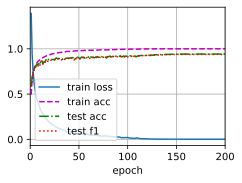

In [11]:
num_epochs = 200
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=0.9,weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)#学习率调整策略
criterion = nn.CrossEntropyLoss()

def train(net, trainloader, testloader, num_epochs, optimizer, criterion, device, scheduler=None):
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc', 'test f1'])

    for epoch in range(num_epochs):
        net.train()  # 将模型设置为训练模式
        train_loss, train_acc, train_f1 = 0.0, 0.0, 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
            train_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_f1 /= len(trainloader)

        # 在测试集上验证模型性能
        net.eval()  # 将模型设置为评估模式
        test_loss, test_acc, test_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                test_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
                test_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        test_loss /= len(testloader)
        test_acc /= len(testloader)
        test_f1 /= len(testloader)

        # 输出每个 epoch 的结果
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

        if scheduler:
            if scheduler.__module__ == 'torch.optim.lr_scheduler':
                # 使用 PyTorch 内置的学习率调度器
                scheduler.step()
            else:
                # 使用自定义的学习率调度器
                for param_group in optimizer.param_groups:
                    param_group['lr'] = scheduler(epoch)

        animator.add(epoch+1, (train_loss, train_acc, test_acc, test_f1))
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))
train(net, train_iter, test_iter, num_epochs, optimizer, criterion, device, scheduler)

### Result
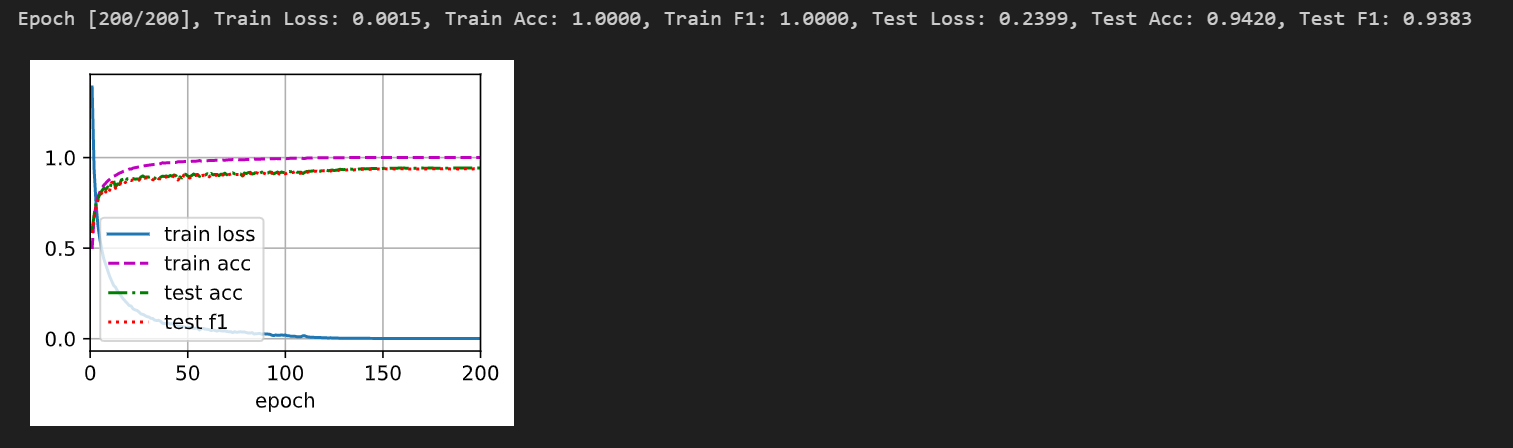
> Epoch [200/200], Train Loss: 0.0015, Train Acc: 1.0000, Test Loss: 0.2399, Test Acc: 0.9420

#### train( )函数
`train()`函数是一个基于PyTorch的函数，用于训练神经网络模型。它需要以下参数：
* `net`： 要训练的神经网络模型。
* `trainloader`： 训练数据加载器。
* `testloader`： 测试数据加载器。
* `num_epochs`： 训练的历时数。
* `optimizer`： 训练时使用的优化器。
* `criterion`： 训练中使用的损失函数。
* `device`： 训练模型的设备（CPU或GPU）。
* `scheduler`： 学习率调度器（可选）。

函数首先调用 `d2l`中`Animator`类创建一个对象来绘制图像跟踪训练的进展。然后，进入一个指定的轮数的循环。在每轮中，该函数做以下工作：

1. 将模型设置为训练模式。
2. 遍历训练数据加载器，对每批数据进行前向传递和后向传递。
3. 使用优化器更新模型参数。
4. 计算训练损失和准确性。
5. 在测试数据上评估模型，并计算测试损失和准确性、F1
6. 将所得的损失和准确率、F1在图像中更新

若使用了一个学习率调度器，`train`函数将在每个历时结束时更新学习率。

`train()`函数打印出训练损失和准确率，以及测试损失和准确率。

#### 参数说明
参数说明如下：

- Learning Rate（学习率）：0.01
- Batch Size（批大小）for train：128
- Batch Size（批大小）for test：100
- Epochs（训练轮数）：200
- Weight Decay（权重衰减）：5e-4
- Momentum（动量）：0.9。动量系数为 0.9，当前的梯度更新方向受到 90% 的动量影响